In [67]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random

# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

In [68]:
# Generate a random matrix
x = random.uniform(key, (1000, 1000))
# Compare running times of 3 different matrix multiplications
%time y = onp.dot(x, x)
%time y = np.dot(x, x)
%time y = np.dot(x, x).block_until_ready()

CPU times: user 68.7 ms, sys: 44.9 ms, total: 114 ms
Wall time: 104 ms
CPU times: user 72.2 ms, sys: 27.2 ms, total: 99.4 ms
Wall time: 66.7 ms
CPU times: user 67.9 ms, sys: 11.1 ms, total: 79 ms
Wall time: 52.5 ms


In [69]:
# Generate a random matrix
x = random.uniform(key, (1000, 1000))
# Compare running times of 3 different matrix multiplications
%time y = onp.dot(x, x)
%time y = np.dot(x, x)
%time y = np.dot(x, x).block_until_ready()


CPU times: user 61.7 ms, sys: 12.9 ms, total: 74.6 ms
Wall time: 81.6 ms
CPU times: user 70.1 ms, sys: 11.9 ms, total: 82.1 ms
Wall time: 110 ms
CPU times: user 58.5 ms, sys: 35 µs, total: 58.5 ms
Wall time: 114 ms


In [70]:
def ReLU(x):
    """ Rectified Linear Unit (ReLU) activation function """
    return np.maximum(0, x)

jit_ReLU = jit(ReLU)

In [71]:
%time out = ReLU(x).block_until_ready()
# Call jitted version to compile for evaluation time!
%time jit_ReLU(x).block_until_ready()
%time out = jit_ReLU(x).block_until_ready()

CPU times: user 2.06 ms, sys: 3 µs, total: 2.06 ms
Wall time: 2.85 ms
CPU times: user 59 ms, sys: 1.99 ms, total: 61 ms
Wall time: 154 ms
CPU times: user 2.29 ms, sys: 10 µs, total: 2.3 ms
Wall time: 1.27 ms


In [72]:
def FiniteDiffGrad(x):
    """ Compute the finite difference derivative approx for the ReLU"""
    return np.array((ReLU(x + 1e-3) - ReLU(x - 1e-3)) / (2 * 1e-3))

# Compare the Jax gradient with a finite difference approximation
print("Jax Grad: ", jit(grad(jit(ReLU)))(2.))
print("FD Gradient:", FiniteDiffGrad(2.))

Jax Grad:  1.0
FD Gradient: 0.99998707


In [73]:
batch_dim = 32
feature_dim = 100
hidden_dim = 512

# Generate a batch of vectors to process
X = random.normal(key, (batch_dim, feature_dim))

# Generate Gaussian weights and biases
params = [random.normal(key, (hidden_dim, feature_dim)),
          random.normal(key, (hidden_dim, ))] 

def relu_layer(params, x):
    """ Simple ReLu layer for single sample """
    return ReLU(np.dot(params[0], x) + params[1])

def batch_version_relu_layer(params, x):
    """ Error prone batch version """
    return ReLU(np.dot(X, params[0].T) + params[1])

def vmap_relu_layer(params, x):
    """ vmap version of the ReLU layer """
    return jit(vmap(relu_layer, in_axes=(None, 0), out_axes=0))

out = np.stack([relu_layer(params, X[i, :]) for i in range(X.shape[0])])
out = batch_version_relu_layer(params, X)
out = vmap_relu_layer(params, X)

In [74]:
!pip install ml-helper

In [75]:
from ml_helper.helper import Helper

In [76]:
KEYS = {
    'SEED': 1,
    'TARGET': 'y',
    'METRIC': 'r2',
    'TIMESERIES': True,
    'SPLITS': 5
}

hp = Helper(KEYS)

In [77]:
import torch
import torchvision

In [78]:
# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.experimental import optimizers

import torch
from torchvision import datasets, transforms

import time


In [79]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [80]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('../data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)


In [81]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

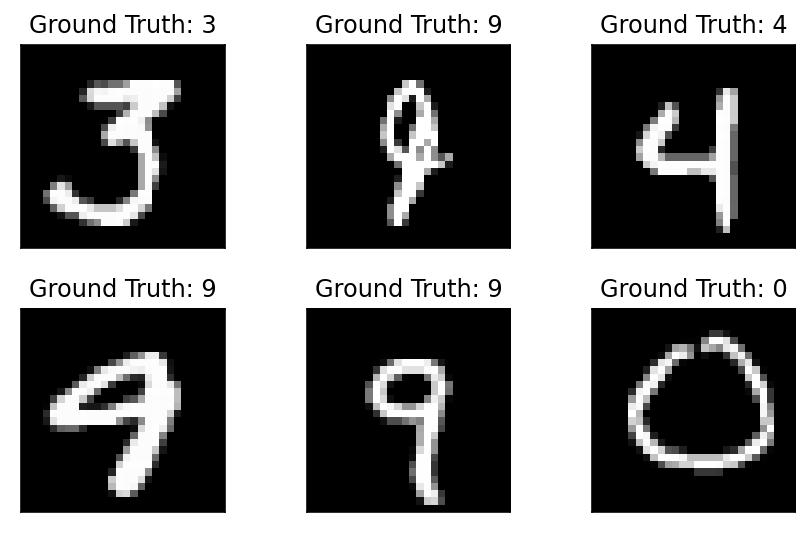

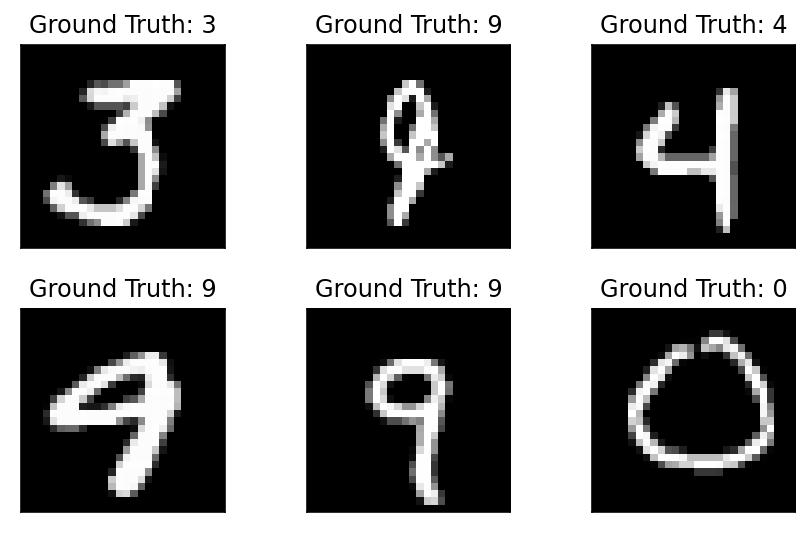

In [82]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [83]:
def initialize_mlp(sizes, key):
    """ Initialize the weights of all layers of a linear layer network """
    keys = random.split(key, len(sizes))
    # Initialize a single layer with Gaussian weights -  helper function
    def initialize_layer(m, n, key, scale=1e-2):
        w_key, b_key = random.split(key)
        return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))
    return [initialize_layer(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 512, 10]
# Return a list of tuples of layer weights
params = initialize_mlp(layer_sizes, key)

In [84]:
def forward_pass(params, in_array):
    """ Compute the forward pass for each example individually """
    activations = in_array
    
    # Loop over the ReLU hidden layers
    for w, b in params[:-1]:
        activations = relu_layer([w, b], activations)
    
    # Perform final trafo to logits
    final_w, final_b = params[-1]
    logits = np.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

# Make a batched version of the `predict` function
batch_forward = vmap(forward_pass, in_axes=(None, 0), out_axes=0)

In [85]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k """
    return np.array(x[:, None] == np.arange(k), dtype)

def loss(params, in_arrays, targets):
    """ Compute the multi-class cross-entropy loss """
    preds = batch_forward(params, in_arrays)
    return -np.sum(preds * targets)
  
def accuracy(params, data_loader):
    """ Compute the accuracy for a provided dataloader """
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        images = np.array(data).reshape(data.size(0), 28*28)
        targets = one_hot(np.array(target), num_classes)
    
        target_class = np.argmax(targets, axis=1)
        predicted_class = np.argmax(batch_forward(params, images), axis=1)
        acc_total += np.sum(predicted_class == target_class)
    return acc_total/len(data_loader.dataset)

In [86]:
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_epochs = 10
num_classes = 10


In [87]:
def run_mnist_training_loop(num_epochs, opt_state, net_type="MLP"):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []
    
    # Get the initial set of parameters 
    params = get_params(opt_state)
    
    # Get initial accuracy after random init
    train_acc = accuracy(params, train_loader)
    test_acc = accuracy(params, test_loader)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)
    
    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        for batch_idx, (data, target) in enumerate(train_loader):
            if net_type == "MLP":
                # Flatten the image into 784 vectors for the MLP
                x = np.array(data).reshape(data.size(0), 28*28)
            elif net_type == "CNN":
                # No flattening of the input required for the CNN
                x = np.array(data)
            y = one_hot(np.array(target), num_classes)
            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        train_acc = accuracy(params, train_loader)
        test_acc = accuracy(params, test_loader)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | T: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))
    
    return train_loss, log_acc_train, log_acc_test


train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state,
                                                          net_type="MLP")



Epoch 1 | T: 29.71 | Train A: 0.977 | Test A: 0.971
Epoch 2 | T: 29.81 | Train A: 0.983 | Test A: 0.976
Epoch 3 | T: 28.42 | Train A: 0.987 | Test A: 0.974
Epoch 4 | T: 28.19 | Train A: 0.989 | Test A: 0.976
Epoch 5 | T: 28.41 | Train A: 0.994 | Test A: 0.979
Epoch 6 | T: 28.17 | Train A: 0.994 | Test A: 0.978
Epoch 7 | T: 28.65 | Train A: 0.996 | Test A: 0.980
Epoch 8 | T: 28.10 | Train A: 0.997 | Test A: 0.980
Epoch 9 | T: 28.45 | Train A: 0.997 | Test A: 0.981
Epoch 10 | T: 28.32 | Train A: 0.998 | Test A: 0.982
